# Footprint AK batches of TOAs and SRLite and build VHR dataframes

In [1]:
import glob
from osgeo import gdal, ogr, osr
import geopandas as gpd
import pandas as pd
import sys, os
sys.path.append('/home/pmontesa/code/dgtools')
sys.path.append('/home/pmontesa/code/pygeotools')
import pygeotools 

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib

# This is a private repo
from dgtools.lib import dglib

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from multiprocessing import Pool
from functools import partial

from scipy import ndimage

import contextily as ctx

/tmp/ipykernel_1838889/3700435490.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


*** With list of catids from some database search, run `EVHR` to get TOAs  


### Dirs

In [34]:
MAINDIR = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1'
MAINDIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
OUTDIR = '/explore/nobackup/people/pmontesa/srlite'

#TARGET = 'Alaska_ahri_20221004'
#TARGET_DIR_TOA = f'/explore/nobackup/projects/ilab/data/srlite/toa/{TARGET}'

TARGET = 'alaska_2nd_batch'
TARGET = 'alaska*'
TARGET = '002m'
TARGET_DIR_TOA = f'{MAINDIR}/toa/{TARGET}'

# Cloudmask dir
TARGET_DIR_CLOUDMASK = f'{MAINDIR}/cloudmask/{TARGET}'

# Final SRLite output
#TARGET = 'alaska*'
TARGET_DIR_SR = f'{MAINDIR}/srlite/{TARGET}'

# TOA: Build geodataframe of footprints
from huge Alaska request 

In [8]:
print(pd.Timestamp.now())
# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)

# Get the list of filenames
#SEARTH_STRING = '/*/*/5-toas/*toa.tif'
SEARTH_STRING = '/split_*/5-toas/*.xml'
SEARTH_STRING = '/*toa.xml'

#SEARTH_STRING = '/**/*M1BS*-toa.xml'

f_list_toa_xml = glob.glob(f"{TARGET_DIR_TOA}{SEARTH_STRING}", recursive=True)
print(f'Search returned {len(f_list_toa_xml)} TOA XMLs')

#f_list_toa = [f.replace('toa.xml', 'toa.tif') for f in f_list_toa_xml if os.path.getsize(f.replace('xml','tif')) > 0 and os.path.isfile(f.replace('xml','tif'))  ]
f_list_toa = [f.replace('toa.xml', 'toa.tif') for f in f_list_toa_xml if  os.path.isfile(f.replace('xml','tif'))  ] # after move, change to '-ccog.tig'
print(f'Search returned {len(f_list_toa)} TOA XMLs with corresponding TIFs')


2023-10-31 17:25:51.107879
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m
Search returned 3323 TOA XMLs
Search returned 3323 TOA XMLs with corresponding TIFs


In [9]:
f"{TARGET_DIR_TOA}{SEARTH_STRING}"

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m/*toa.xml'

In [10]:
f_list_toa[-1]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m/WV03_20200805_M1BS_104001005F61AB00-toa.tif'

In [11]:
from multiprocessing import Pool
from functools import partial

In [12]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list_toa)

CPU times: user 549 ms, sys: 213 ms, total: 762 ms
Wall time: 16.1 s


In [13]:
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa = footprintlib.get_attributes_from_filename(footprint_gdf_toa, 'TOA', '-toa')
footprint_gdf_toa.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3323 entries, 0 to 3322
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            3323 non-null   object        
 1   geometry        3323 non-null   geometry      
 2   footprint_name  3323 non-null   object        
 3   path            3323 non-null   object        
 4   area_km2        3323 non-null   float64       
 5   area_ha         3323 non-null   float64       
 6   type            3323 non-null   object        
 7   catid           3323 non-null   object        
 8   sensor          3323 non-null   object        
 9   year            3323 non-null   int64         
 10  month           3323 non-null   int64         
 11  date            3323 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(6)
memory usage: 337.5+ KB


## TOA data for all of Alaska

<Axes: >

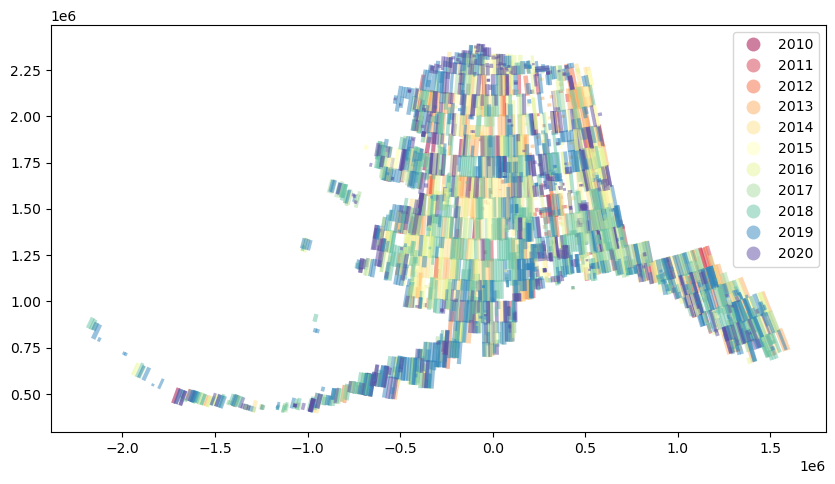

In [22]:
footprint_gdf_toa['year_cat'] = footprint_gdf_toa['year'].astype('category')
footprint_gdf_toa.to_crs(3338).plot(figsize=(10,10), alpha=0.5, column='year_cat', cmap='Spectral', legend=True, 
                                    #legend_kwds={'label': "Acquisition year", "location":'top', 'shrink': 0.5, 'orientation': "horizontal"}
                                   )
    #

In [12]:
footprint_gdf_toa.head()

,file,geometry,footprint_name,path,area_km2,area_ha,type,catid,sensor,year,month,date
0,WV02_20130707_M1BS_1030010024338600-toa.tif,"POLYGON ((-129.21761 55.95624, -129.22384 57.0...",WV02_20130707_M1BS_1030010024338600,/explore/nobackup/projects/ilab/data/srlite/pr...,2189.827944,218982.7944,TOA,1030010024338600,WV02,2013,7,2013-07-07
1,WV02_20130714_M1BS_103001002503EF00-toa.tif,"POLYGON ((-130.93496 55.94863, -130.99172 57.0...",WV02_20130714_M1BS_103001002503EF00,/explore/nobackup/projects/ilab/data/srlite/pr...,2946.255180,294625.5180,TOA,103001002503EF00,WV02,2013,7,2013-07-14
2,WV02_20130714_M1BS_10300100252F2900-toa.tif,"POLYGON ((-131.21966 55.95564, -131.28334 57.0...",WV02_20130714_M1BS_10300100252F2900,/explore/nobackup/projects/ilab/data/srlite/pr...,2917.563440,291756.3440,TOA,10300100252F2900,WV02,2013,7,2013-07-14
3,WV02_20130718_M1BS_1030010025958C00-toa.tif,"POLYGON ((-130.56024 56.95492, -130.60711 58.0...",WV02_20130718_M1BS_1030010025958C00,/explore/nobackup/projects/ilab/data/srlite/pr...,3202.375820,320237.5820,TOA,1030010025958C00,WV02,2013,7,2013-07-18
4,WV02_20130912_M1BS_1030010025674800-toa.tif,"POLYGON ((-128.95965 53.93621, -128.95854 55.0...",WV02_20130912_M1BS_1030010025674800,/explore/nobackup/projects/ilab/data/srlite/pr...,2889.244400,288924.4400,TOA,1030010025674800,WV02,2013,9,2013-09-12


## Make a dictionary of VHR metadata
Use dgtools to pull out metadata for list of TOAs in a dir

### Get the VHR metadata for the big Alaska set of TOAs

In [36]:
nowtime = pd.Timestamp.now().strftime('%Y%m%d')

In [ ]:
%%time

import importlib
importlib.reload(vhrlib)

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)
vhr_df.info()

vhr_df.to_csv(f'{OUTDIR}/vhr_toa_metadata_{TARGET}_{nowtime}.csv') # /explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/tables

### Show acquisition geometry 

In [25]:
# Prefer to join VHR df to my footprints
footprints_vhr_meta_gdf = pd.merge(footprint_gdf_toa, vhr_df[['satid','catid', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'catid', copy=False)

In [26]:
footprints_vhr_meta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3323 entries, 0 to 3322
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            3323 non-null   object        
 1   geometry        3323 non-null   geometry      
 2   footprint_name  3323 non-null   object        
 3   path            3323 non-null   object        
 4   area_km2        3323 non-null   float64       
 5   area_ha         3323 non-null   float64       
 6   type            3323 non-null   object        
 7   catid           3323 non-null   object        
 8   sensor          3323 non-null   object        
 9   year            3323 non-null   int64         
 10  month           3323 non-null   int64         
 11  date            3323 non-null   datetime64[ns]
 12  year_cat        3323 non-null   category      
 13  satid           3323 non-null   object        
 14  el              3323 non-null   float64       
 

<Axes: >

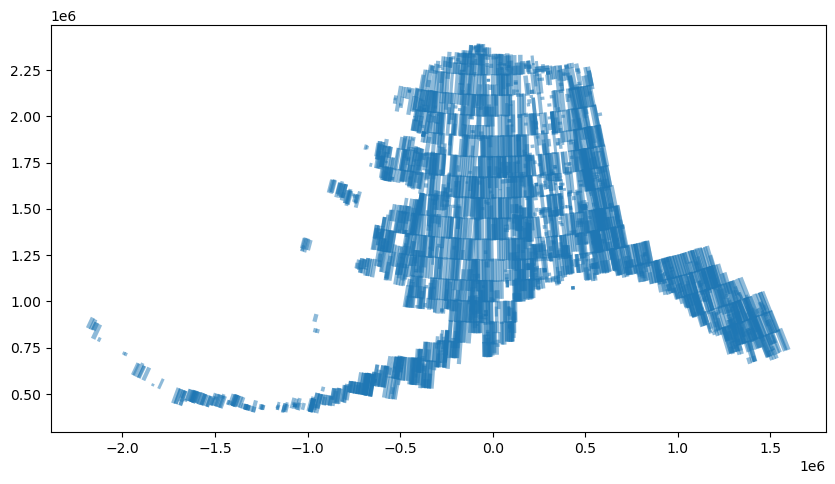

In [27]:
footprint_gdf_toa.to_crs(3338).plot(figsize=(10,10), alpha=0.5) #

## Save TOA footprints for CCDC creation

In [37]:
out_gdf_fn = f'{OUTDIR}/footprints_vhrmeta_toa_{TARGET}_{nowtime}.gpkg'
out_gdf_fn

'/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_toa_002m_20231031.gpkg'

In [38]:
footprints_vhr_meta_gdf.drop(columns=['year_cat']).to_file(out_gdf_fn, driver='GPKG')
#footprints_vhr_meta_gdf.drop(columns=['date']).to_file(out_gdf_fn.replace('gpkg','shp'))
out_gdf_fn

'/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_toa_002m_20231031.gpkg'

## Read back in the TOA footprints file

In [13]:
import importlib
importlib.reload(footprintlib)
importlib.reload(vhrlib)

<module 'vhrlib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/vhrlib.py'>

In [10]:
footprints_vhr_meta_gdf = gpd.read_file(out_gdf_fn)

<AxesSubplot: >

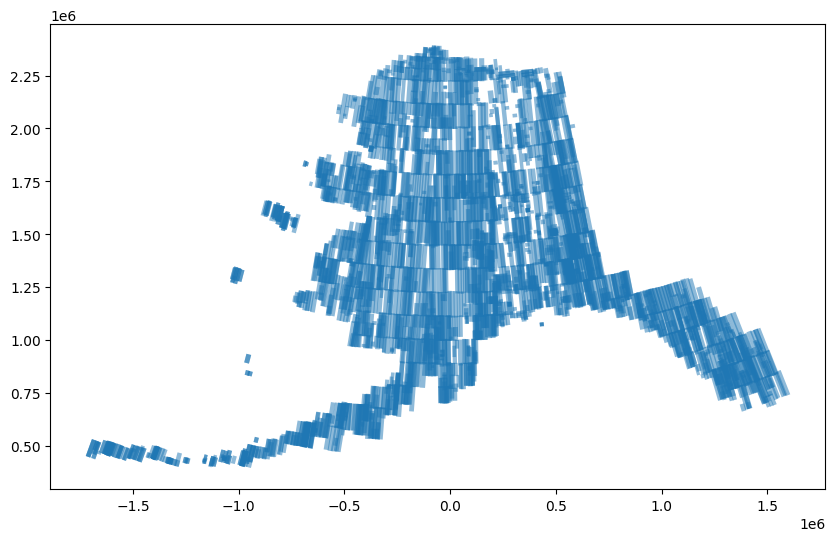

In [142]:
footprints_vhr_meta_gdf.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,10), alpha=0.5) 

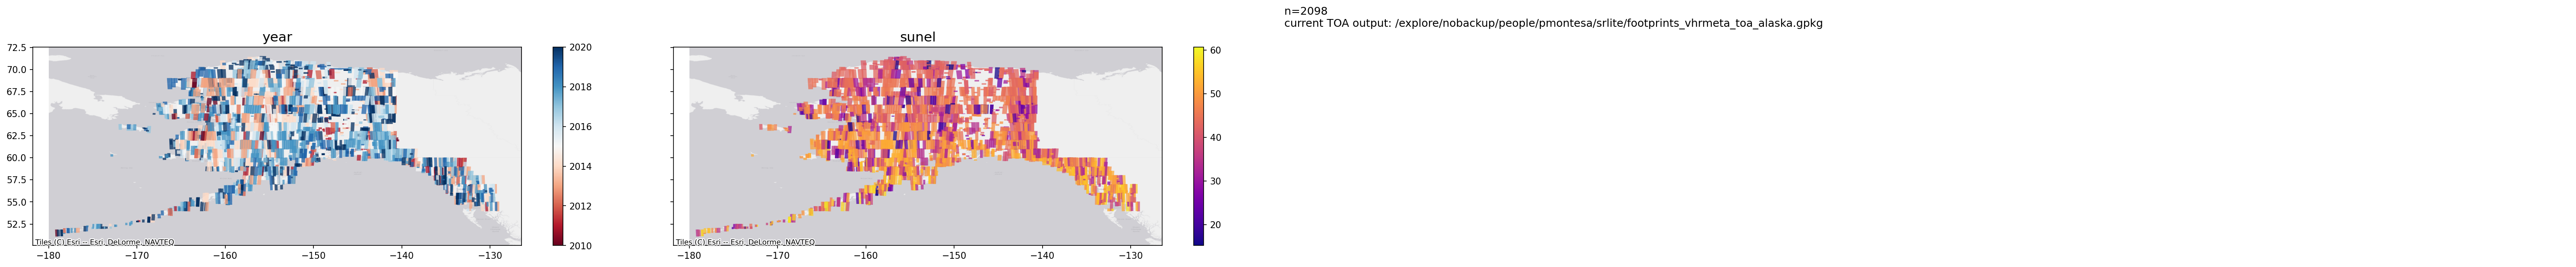

In [22]:
#MAP_SUBPLOTS(footprints_vhr_meta_gdf.cx[-180:-125,50:75], out_gdf_fn)
vhrlib.MAP_SUBPLOTS(footprints_vhr_meta_gdf.cx[-180:-125,50:75], f'\ncurrent TOA output: {out_gdf_fn}', col_list = ['year', 'sunel'], categorical_list=[False, False])

# SRlite: Build footprints geodataframe 

In [15]:
# Get footprints gdf from a target dir
TARGET_DIR_SR = TARGET_DIR_SR.rstrip('/')
print(TARGET_DIR_SR)

f_list_sr_dict = dict()
BATCH_LIST = ['batch_1', 'batch_2']

for BATCH in BATCH_LIST:
    # Get the list of filenames
    #SEARTH_STRING = '/*/*/5-toas/*toa.tif'
    SEARTH_STRING_4band = f'{BATCH}/4_band*/**/*sr-02m.tif'
    SEARTH_STRING_8band = f'{BATCH}/8_band*/**/*sr-02m.tif'

    for SEARTH_STRING in [SEARTH_STRING_4band, SEARTH_STRING_8band]:

        f_list_sr = glob.glob(f"{TARGET_DIR_SR}{SEARTH_STRING}", recursive=True)
        #f_list_sr = [os.path.basename(x) for x in f_list_sr]
        f_list_sr_dict.update([(SEARTH_STRING, f_list_sr)])
        print(f'Search returned for {SEARTH_STRING}: {len(f_list_sr)} SRs')

/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska*
Search returned for batch_1/4_band*/**/*sr-02m.tif: 165 SRs
Search returned for batch_1/8_band*/**/*sr-02m.tif: 1917 SRs
Search returned for batch_2/4_band*/**/*sr-02m.tif: 0 SRs
Search returned for batch_2/8_band*/**/*sr-02m.tif: 1145 SRs


### Get full list of SRlite across all batches

In [16]:
f_list_sr_FULL = []
for k,v in f_list_sr_dict.items():
    f_list_sr_FULL += v
len(f_list_sr_FULL)

3227

In [ ]:
%%time
# Make footprint gdfs of the the filenames, concat to single gdf
if False:
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr_FULL]
else:
    with Pool(processes=35) as pool:
        f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list_sr_FULL)

In [ ]:
footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_sr.info()

In [ ]:
footprint_gdf_sr.head()

In [ ]:
#footprint_gdf_sr.groupby('path').aggregate({ 'path':'count'})
footprint_gdf_sr['subdir'] = footprint_gdf_sr['path'].str.split(TARGET_DIR_SR, expand=True)[1]#.str.split('/split', expand=True)[0]
footprint_gdf_sr.head()

## Drop duplicates in complete set of srlite across all alaska batches

In [ ]:
footprint_gdf_sr = footprintlib.get_attributes_from_filename(footprint_gdf_sr, 'SR', '-sr', DROP_FILE_DUPLICATES=True)
footprint_gdf_sr.info()

<Axes: >

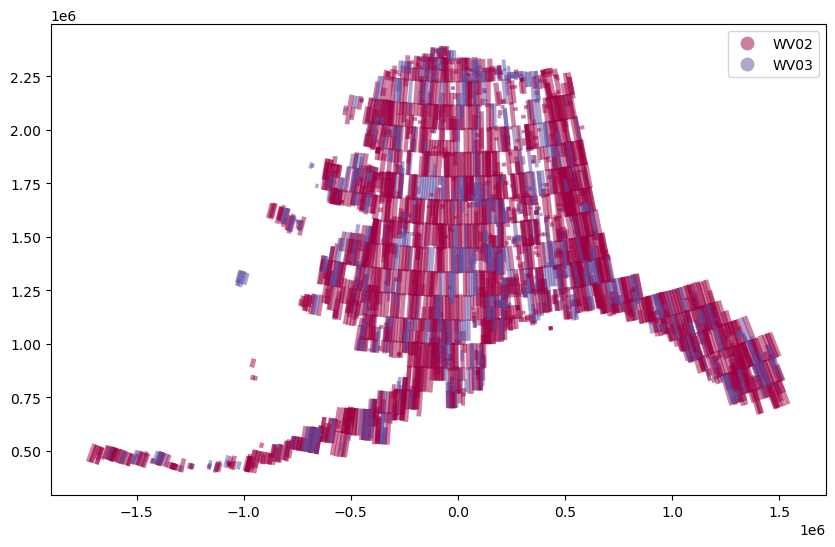

In [16]:
footprint_gdf_sr.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,10), alpha=0.5, column='sensor', cmap='Spectral', legend=True) 

In [17]:
footprint_gdf_sr.groupby('path').aggregate({'path':'count'})

,path
path,
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band/split_3,1
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band/split_5,1
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band/split_6,1
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band_csv,162
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_10,23
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_2,52
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_3,150
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_4,258
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_5,257


In [ ]:
out_gdf_SR_fn = f'{OUTDIR}/footprints_vhrmeta_SR_{TARGET}.gpkg'

if True:
    # Prefer to join VHR df to my footprints
    footprints_vhr_meta_SR_gdf = pd.merge(footprint_gdf_sr, vhr_df[['satid','catid', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'catid', copy=False)
    print( f"# {TARGET} images with metadata: {footprints_vhr_meta_SR_gdf.shape[0]}")
    footprints_vhr_meta_SR_gdf.to_file(out_gdf_SR_fn, driver='GPKG')
    footprints_vhr_meta_SR_gdf.drop(columns=['date']).to_file(out_gdf_SR_fn.replace('gpkg','shp'))
else:
    print( f"# {TARGET} images without metadata: {footprint_gdf_sr.shape[0]}")
    footprint_gdf_sr.head()


out_gdf_SR_fn

In [27]:
footprints_vhr_meta_SR_gdf = gpd.read_file(f'{OUTDIR}/footprints_vhrmeta_SR_alaska.gpkg')

In [54]:
footprints_vhr_meta_SR_gdf['fn'] = footprints_vhr_meta_SR_gdf['path'].astype(str) + '/' + footprints_vhr_meta_SR_gdf['file'].astype(str)

In [ ]:
cols_list = ['month', 'sunel', 'sunaz', 'el', 'az']
cmap_list = ['Spectral', 'plasma','magma','viridis','inferno']
for i, col in enumerate(cols_list):
    ax = footprints_vhr_meta_SR_gdf.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,5), alpha=0.5, column=cols_list[i], cmap=cmap_list[i], legend=True) 
    ax.set_title("SRlite " + cols_list[i])

In [ ]:
#vhrlib.MAP_SUBPLOTS(footprints_vhr_meta_SR_gdf.cx[-180:-125,50:75].to_crs(3338), f'\ncurrent SRlite output: {out_gdf_SR_fn}', col_list = ['year', 'sunel'], categorical_list=[False, False])

# Footprint the cloudmask
To really know where valid data from SRlite exists, footprint the cloudmask

In [6]:
import importlib
import footprintlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/footprintlib.py'>

In [7]:
CLOUDDIR = os.path.join(MAINDIR, 'cloudmask')

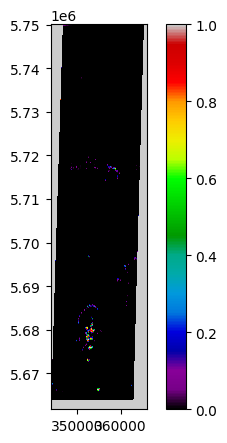

In [8]:
import rasterio as rio
from rasterio.crs import CRS
from rasterio.plot import show_hist, show
vhrlib.map_image_band('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_10/WV02_20101003_M1BS_103001000772AA00-toa.cloudmask.tif', band_num=1, vmin=0, vmax=1)

In [8]:
# Get footprints gdf from a target dir
TARGET_CLOUDDIR = CLOUDDIR.rstrip('/')
print(TARGET_CLOUDDIR)

# Get the list of filenames
#SEARTH_STRING = '/*/*/5-toas/*toa.tif'
SEARTH_STRING = '/split_*/*cloudmask.tif'

f_list_cloudmask = glob.glob(f"{TARGET_CLOUDDIR}{SEARTH_STRING}", recursive=True)
print(f'Search returned {len(f_list_cloudmask)} cloudmasks')

/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask
Search returned 2107 cloudmasks


In [9]:
# # Make footprint gdfs of the the filenames, concat to single gdf
# f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=True, MASK_OUT_VALUE=255, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_cloudmask[0:1]]
# footprint_gdf_cloudmask = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)

## Return a GDF of the SRLite areas of good pixels
resulting from a dilation of the cloudmask that will permit tiles of size N_ITER x 2

In [10]:
LAND_VAL = 0
CLOUD_VAL = 1
N_ITER=128
TARGET

'alaska'

#### Get the list of strip names from the paths of SRLite

In [13]:
stripname_list = [os.path.basename(f).split('-sr')[0] for f in f_list_sr]
print(len(stripname_list))
stripname_list[0]


2075


'WV02_20170828_M1BS_103001006E044100'

#### Get the list of paths to cloudmasks that correspond to strip names from the paths of SRLite

In [14]:
f_list_cloudmask_final = [cloudmask for cloudmask in f_list_cloudmask for stripname in stripname_list if stripname in cloudmask]
print(len(f_list_cloudmask_final))
f_list_cloudmask_final[0]

2079


'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_2/WV02_20100726_M1BS_1030010005C35F00-toa.cloudmask.tif'

In [15]:
# Get missing
list_footprints_cloudmask_finished = [os.path.basename(f).split('-toa.cloudmask')[0] for f in glob.glob(os.path.join(OUTDIR, 'tmp') + '/*.gpkg' )]
print(len(list_footprints_cloudmask_finished))
print(list_footprints_cloudmask_finished[0])

#list_footprints_cloudmask_missing = [stripname for stripname in stripname_list if stripname not in list_footprints_cloudmask_finished]
list_footprints_cloudmask_missing = [r_fn for r_fn in f_list_cloudmask_final if os.path.basename(r_fn).split('-toa.cloudmask')[0] not in list_footprints_cloudmask_finished]

print(len(list_footprints_cloudmask_missing))
print(list_footprints_cloudmask_missing[0])

2072
WV02_20100726_M1BS_1030010005C35F00
1
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_6/WV02_20170928_M1BS_103001007388B900-toa.cloudmask.tif


### Multiprocess indiv cloudmask GDFs

In [ ]:
if True:
    f_gdf_lst = [footprintlib.footprint_cloudmask(r_fn, CLOUD_VAL, INVERT=False, N_ITER=N_ITER, OUTDIR=os.path.join(OUTDIR, 'tmp')) for r_fn in list_footprints_cloudmask_missing]
else:
    from multiprocessing import Pool
    from functools import partial

    with Pool(processes=30) as pool:
        pool.map(partial(footprintlib.footprint_cloudmask, NEW_NDV=CLOUD_VAL, INVERT=False, N_ITER=N_ITER, OUTDIR=os.path.join(OUTDIR, 'tmp')), list_footprints_cloudmask_missing)

### Build a single GDF of all indiv cloudmask footprints for SRLite

In [ ]:
f_gdf_lst = [ gpd.read_file(footprint_fn) for footprint_fn in glob.glob(os.path.join(OUTDIR, 'tmp')+'/*gpkg')]

In [ ]:
footprint_gdf_cloudmask = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)

In [ ]:
out_gdf_SR_CLOUDMASK_fn = f'{OUTDIR}/footprints_vhr_SR_CLOUDMASK_{TARGET}.gpkg'
footprint_gdf_cloudmask.to_file(out_gdf_SR_CLOUDMASK_fn, driver='GPKG')

In [ ]:
footprint_gdf_cloudmask.boundary.plot()
#footprint_gdf_cloudmask[footprint_gdf_cloudmask.raster_val==0].plot()

In [ ]:
footprint_gdf_cloudmask

In [ ]:
footprint_gdf_cloudmask.plot(column='file')